# Optimizer for Call Center Model with delays 

Customers always enter in the first slot of the server 

In [20]:
using JuMP
using HiGHS
using Juniper

include("utils.jl") # demand_generator_mat, printTable, plotData
include("CC_with_delay.jl")

optimize_model (generic function with 2 methods)

## Initial parameters definition

In [ ]:
# Parameters
horiz = 20        # total horizon
c_blr = 5       # weight of balking rate cost
c_ser = 1         # weight of server cost  

# bounds
YM = 10           # max buffer legnth before dropping calls
XM = 6            # max queue length 
phiM = 4          # max adimission to queue
serM = 5          # number of servers
tserM = 3         # max service time

# iniital conditions
X0 = 3
Y0 = 2
L0 = 0
Z0 = 0

struct initial_conditions
    X0
    Y0
    L0
    Z0
end
ic = initial_conditions(X0, Y0, L0, Z0)

struct bounds
    XM
    YM
    phiM
    serM
end
bds = bounds(XM, YM, phiM, serM)


createDemands = false
if createDemands
    d_mat = demand_generator_mat(1, 20, 5, "uniform", 1)
    a_mat = demand_generator_mat(1, 20, 1,"uniform",0.5)
else
    d_fn = "..//CC_simple//d_mat_Thu_22_May_2025_19_39_50.txt";
    a_fn = "..//CC_simple//a_mat_Thu_22_May_2025_19_39_50.txt";
    d_mat = DelimitedFiles.readdlm(d_fn);
    a_mat = DelimitedFiles.readdlm(a_fn);
    
end

d = d_mat[1:horiz, 1];  # demand for incoming calls
a = a_mat[1:horiz, 1];  # abandonment for calls

std_dev = 1 # standard deviation for the random abandonment

c_cin = 1.0        # weight of served clients
c_ser = 1.1        # weight of server cost  

rnd_tser = true    # random service time. If false, max service time is used

1

## Optimization with $\phi$ as control variable

Number of active servers is constant and equal to max.

List of variables modified by $\phi(k)$:

- $n(k)$
- $q(k)$
- $dr(k)$
- $Y(k+1)$
- $X(k+1)$
- $L(k+1)$


Objective function: maximize $f(k)$

$f(k) = \phi(k) - L(k+1)$

In [ ]:

J = zeros(horiz)            # cost function
X = zeros(Int, horiz+1)     # current number of customers in queue x(k)
Y = zeros(Int, horiz+1)     # current number of customers in buffer y(k)  
Z = zeros(Int, horiz+1)     # custumers served  
L = zeros(Int, horiz+1)     # number of customers lost

n = zeros(Int, horiz+1)     # number of empty slots in the queue
Q = zeros(Int, horiz+1)     # custumers entering queue
dr = zeros(Int, horiz+1)    # dropped due to full buffer

phi = zeros(Int, horiz+1)     # number of customers admitted to queue
Cin = zeros(Int, horiz+1)     # number of customers entering server
Cout = zeros(Int, horiz+1)    # number of customers leaving server

S = zeros(Int, horiz+1)                 # number of active servers
Sl = zeros(Int, horiz+1)                # number of free servers
Sst = zeros(Bool, horiz+1, serM)        # server status (0 - free, 1 - busy)
Sc = zeros(Bool, horiz+1, serM, tserM)  # server conveyor
Sin = zeros(Bool, horiz+1, serM, tserM) # server input

Saux = zeros(Bool, horiz+1, serM)       # auxiliary server variable
b1_opt = zeros(horiz)
b2_opt = zeros(horiz)

B = zeros(Float64, horiz+1)                # balking rate

# initial conditions
X[1] = X0
Y[1] = Y0
L[1] = L0
Z[1] = Z0

transition_matrix = zeros(Bool, tserM, tserM)
for i in 1:tserM-1
    transition_matrix[i, i+1] = 1
end

if !rnd_tser
    default_input = zeros(Bool, serM, tserM)  # default input (case with constant service time)
    for i in 1:serM
        default_input[i, 1] = 1
    end
end

In [18]:
for t in 1:horiz
    cc_lin_conv = Model(HiGHS.Optimizer)
    set_silent(cc_lin_conv)

    a[t] = min(X[t], max(0, Int.(round.(X[t]/4 .+ rand(Normal(0, std_dev))))))

    if rnd_tser
        default_input = zeros(Bool, serM, tserM)  
        for i in 1:serM
            slot = rand(1:tserM)  # randomly select a slot for each server
            default_input[i, slot] = 1
        end
    end

    M1 = max(d[t], YM) + 10; # must be larger than d[t] and n[t] 
    @variable(cc_lin_conv, b1, Bin);

    M2 = max(X[t], serM) + 10; # must be larger than x[k] and Sl[k]
    @variable(cc_lin_conv, b2, Bin);

    @variable(cc_lin_conv, 0 <= XL[1:2] <= XM, Int)    
    @variable(cc_lin_conv, 0 <= YL[1:2] <= YM, Int)     
    @variable(cc_lin_conv, 0 <= ZL[1:2], Int)  
    @variable(cc_lin_conv, 0 <= LL[1:2], Int)         
                           
    @variable(cc_lin_conv, 0 <= nL <= YM, Int) 
    @variable(cc_lin_conv, 0 <= QL, Int)      
    @variable(cc_lin_conv, 0 <= drL, Int)   
    
    @variable(cc_lin_conv, 0 <= phiL <= phiM, Int)   
    @variable(cc_lin_conv, 0 <= CinL <= serM, Int)   
    @variable(cc_lin_conv, 0 <= CoutL[1:2] <= serM, Int)    

    @variable(cc_lin_conv, 0 <= SL <= serM, Int)  
    @variable(cc_lin_conv, 0 <= SlL <= serM, Int)  
    @variable(cc_lin_conv, 0 <= SstL[1:serM], Bin)  
    @variable(cc_lin_conv, 0 <= ScL[1:2, 1:serM, 1:tserM], Bin) 
    @variable(cc_lin_conv, 0 <= SinL[1:serM, 1:tserM], Bin)
    @variable(cc_lin_conv, 0 <= SauxL[1:serM], Bin)

    # @variable(cc_lin_conv, 0 <= BL)  
        
    # Initial conditions of buffer and queue for each optimization
    @constraint(cc_lin_conv, XL[1] == X[t])
    @constraint(cc_lin_conv, YL[1] == Y[t])
    @constraint(cc_lin_conv, ZL[1] == Z[t])
    @constraint(cc_lin_conv, LL[1] == L[t])
    @constraint(cc_lin_conv, CoutL[1] == Cout[t])
    @constraint(cc_lin_conv, ScL[1, :, :] == Sc[t, :, :])  # server conveyor status

    # Problem constraints  
    @constraint(cc_lin_conv, XL[2] == XL[1] + phiL - a[t] - CinL)
    @constraint(cc_lin_conv, YL[2] == YL[1] + QL - phiL)
    @constraint(cc_lin_conv, ZL[2] == ZL[1] + CoutL[1])
    @constraint(cc_lin_conv, LL[2] == LL[1] + drL + a[t])

    @constraint(cc_lin_conv, nL == YM - YL[1] + phiL)  # number of empty slots in the queue
    @constraint(cc_lin_conv, QL <= d[t])
    @constraint(cc_lin_conv, QL <= nL)
    @constraint(cc_lin_conv, QL >= d[t]-M1*b1)
    @constraint(cc_lin_conv, QL >= nL-(1-b1)*M1)  

    @constraint(cc_lin_conv, drL >= d[t]-nL)         
    @constraint(cc_lin_conv, drL <= d[t]-QL) 

    @constraint(cc_lin_conv, SL == serM)              
    @constraint(cc_lin_conv, SstL == sum(ScL[1,:,:], dims=2))  
    @constraint(cc_lin_conv, SlL == SL - sum(SstL))    
    @constraint(cc_lin_conv, [i=1:serM, j=1:tserM], SinL[i, j] == default_input[i, j] .* SauxL[i])
    @constraint(cc_lin_conv, ScL[2, :, :] == ScL[1, :, :]*transition_matrix + SinL)

    @constraint(cc_lin_conv, CinL <= XL[1]-a[t])
    @constraint(cc_lin_conv, CinL <= SlL)
    @constraint(cc_lin_conv, CinL >= XL[1]-a[t]-M2*b2)
    @constraint(cc_lin_conv, CinL >= SlL-(1-b2)*M2)  
    @constraint(cc_lin_conv, CoutL[2] == sum(ScL[1,:,tserM]))  

    @constraint(cc_lin_conv, SauxL <= ones(Bool, serM) - SstL)  
    @constraint(cc_lin_conv, CinL == sum(SauxL))  

    # @constraint(cc_lin_conv, BL == LL[2]/(LL[2]+ZL[2]))  # balking rate non linear constraint

    # Objective function
    @objective(cc_lin_conv, Max, phiL - LL[2]) 

    JuMP.optimize!(cc_lin_conv)

    # if t == 6 || t == 7
    #     println("constraint 1: ", JuMP.value(XL[1])-a[t])
    #     println("constraint 2: ", serM - sum(sum(JuMP.value.(Sc[t, :, :]), dims=2)))
    #     println("constraint 3: ", max(JuMP.value(X[1]), serM)+10)

    #     println("Cin: ", JuMP.value(CinL))
    #     println("Sl: ", JuMP.value(SlL))
    #     println("X: ", JuMP.value(XL[1]))

    #     println("b2: ", JuMP.value(b2))
    #     println("M2: ", JuMP.value(M2))
        
    #     print("Sc")
    #     display(JuMP.value.(ScL[1,:,:]))
    #     print("Sst")
    #     display(JuMP.value.(SstL))
    #     print("Saux")
    #     display(JuMP.value.(SauxL))
    # end
    
    status = termination_status(cc_lin_conv)
    if (status == MOI.OPTIMAL || status == MOI.LOCALLY_SOLVED || status==MOI.ALMOST_LOCALLY_SOLVED) && has_values(cc_lin_conv)
        # Save computed values
        X[t+1] = JuMP.value(XL[2]);
        Y[t+1] = JuMP.value(YL[2]);
        Z[t+1] = JuMP.value(ZL[2]);
        L[t+1] = JuMP.value(LL[2]);

        n[t] = JuMP.value(nL);
        Q[t] = JuMP.value(QL);  
        dr[t] = JuMP.value(drL);
        
        phi[t] = JuMP.value(phiL);
        Cin[t] = JuMP.value(CinL);
        Cout[t+1] = JuMP.value(CoutL[2]);

        S[t] = JuMP.value(SL);
        Sl[t] = JuMP.value(SlL);
        Sst[t, :] = JuMP.value.(SstL);
        Sc[t+1, :, :] = JuMP.value.(ScL[2, :, :]);
        Sin[t, :, :] = JuMP.value.(SinL);
        Saux[t, :] = JuMP.value.(SauxL);

        b1_opt[t] = JuMP.value(b1);
        b2_opt[t] = JuMP.value(b2);

        J[t] = objective_value(cc_lin_conv) # Repeated line

        # Display results
        println("Optimal solution:")
        println("Objective value = ", objective_value(cc_lin_conv))
    else
        println(t, " ", status)
    end
end

Optimal solution:
Objective value = 0.0
Optimal solution:
Objective value = 2.0
Optimal solution:
Objective value = 1.0
Optimal solution:
Objective value = 0.0
Optimal solution:
Objective value = -8.0
Optimal solution:
Objective value = -14.0
Optimal solution:
Objective value = -19.0
Optimal solution:
Objective value = -24.0
Optimal solution:
Objective value = -24.0
Optimal solution:
Objective value = -25.0
Optimal solution:
Objective value = -38.0
Optimal solution:
Objective value = -51.0
Optimal solution:
Objective value = -57.0
Optimal solution:
Objective value = -67.0
Optimal solution:
Objective value = -70.0
Optimal solution:
Objective value = -69.0
Optimal solution:
Objective value = -72.0
Optimal solution:
Objective value = -82.0
Optimal solution:
Objective value = -90.0
Optimal solution:
Objective value = -96.0


In [19]:
data = hcat(1:horiz, d, dr[1:horiz,1], n[1:horiz,1], Q[1:horiz,1], Y[1:horiz,1], phi[1:horiz, 1], X[1:horiz,1], Cin[1:horiz,1], Cout[1:horiz,1], a)
header = (["t", "d", "dr", "n", "q", "Y", "phi", "X", "Cin", "Cout", "a"]);
printTable(data, header)

Results
┌────────┬────────┬────────┬────────┬───────┬────────┬───────┬───────┬───────┬───────┬───────┐
│      t │      d │     dr │      n │     q │      Y │   phi │     X │   Cin │  Cout │     a │
├────────┼────────┼────────┼────────┼───────┼────────┼───────┼───────┼───────┼───────┼───────┤
│  1.000 │  7.000 │  0.000 │ 10.000 │ 7.000 │  2.000 │ 2.000 │ 3.000 │ 1.000 │ 0.000 │ 2.000 │
│  2.000 │  3.000 │  0.000 │  7.000 │ 3.000 │  7.000 │ 4.000 │ 2.000 │ 2.000 │ 0.000 │ 0.000 │
│  3.000 │  3.000 │  0.000 │  8.000 │ 3.000 │  6.000 │ 4.000 │ 4.000 │ 2.000 │ 0.000 │ 1.000 │
│  4.000 │  7.000 │  0.000 │  9.000 │ 7.000 │  5.000 │ 4.000 │ 5.000 │ 3.000 │ 3.000 │ 1.000 │
│  5.000 │ 12.000 │  6.000 │  6.000 │ 6.000 │  8.000 │ 4.000 │ 5.000 │ 1.000 │ 1.000 │ 2.000 │
│  6.000 │  9.000 │  5.000 │  4.000 │ 4.000 │ 10.000 │ 4.000 │ 6.000 │ 3.000 │ 3.000 │ 1.000 │
│  7.000 │  6.000 │  2.000 │  4.000 │ 4.000 │ 10.000 │ 4.000 │ 6.000 │ 1.000 │ 1.000 │ 3.000 │
│  8.000 │  3.000 │  2.000 │  1.000 │ 1.00

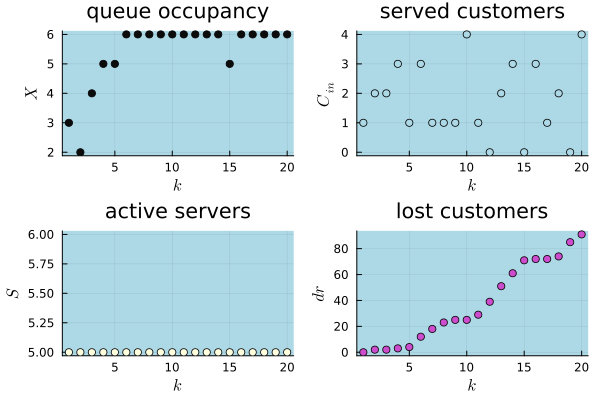

In [20]:
evolution = [X[1:horiz,1], Cin[1:horiz,1], S[1:horiz,1], L[1:horiz,1]]
ylabel = [L"X" L"C_{in}" L"S" L"dr"]
title = ["queue occupancy" "served customers" "active servers" "lost customers"]

plotData(evolution, ylabel, title)

In [21]:
println("Total number of served customers: ", Z[horiz+1])
println("Total number of lost customers: ", L[horiz+1])

Total number of served customers: 30
Total number of lost customers: 100


## Optimization with $\phi$ and S as control variables

List of variables modified by $\phi(k)$:
- $n[k]$
- $q[k]$
- $dr[k]$
- $Y[k+1]$
- $X[k+1]$
- $L[k+1]$

List of variables modified by $S(k)$:
- $S_l[k]$
- $S_{aux}[k]$
- $S_{in}[k]$
- $C_{in}[k]$
- $S_c[k+1]$

Objective function: min $f[x]$

Objective function should only use the variables that are modified by $\phi[k]$ and $S[k]$.

$ f[k] = L[k+1] + c_{ser}\cdot S[k] - c_{cin}\cdot Cin[k] - \phi[k] $

Is there a reason not to always use maximum $\phi$?

In [21]:
X, Y, Z, L, n, Q, dr, phi, Cin, Cout, S, Sl, Sst, Sc, Sin, Saux, b1_opt, b2_opt, J = optimize_model(horiz, a, d, c_cin, c_ser, ic, bds, std_dev, rnd_tser);

In [7]:
data = hcat(1:horiz, d, dr[1:horiz,1], n[1:horiz,1], Q[1:horiz,1], Y[1:horiz,1], phi[1:horiz, 1], X[1:horiz,1], S[1:horiz,1], Cin[1:horiz,1], Cout[1:horiz,1], a)
header = (["t", "d", "dr", "n", "q", "Y", "phi", "X", "S", "Cin", "Cout", "a"]);
printTable(data, header)

Results
┌────────┬────────┬────────┬────────┬───────┬────────┬───────┬───────┬───────┬───────┬───────┬─────┐
│      t │      d │     dr │      n │     q │      Y │   phi │     X │     S │   Cin │  Cout │   a │
├────────┼────────┼────────┼────────┼───────┼────────┼───────┼───────┼───────┼───────┼───────┼─────┤
│  1.000 │  7.000 │  0.000 │ 10.000 │ 7.000 │  2.000 │ 2.000 │ 3.000 │ 0.000 │ 0.000 │ 0.000 │ 2.0 │
│  2.000 │  3.000 │  0.000 │  7.000 │ 3.000 │  7.000 │ 4.000 │ 3.000 │ 0.000 │ 0.000 │ 0.000 │ 1.0 │
│  3.000 │  3.000 │  0.000 │  8.000 │ 3.000 │  6.000 │ 4.000 │ 6.000 │ 2.000 │ 2.000 │ 0.000 │ 2.0 │
│  4.000 │  7.000 │  0.000 │  9.000 │ 7.000 │  5.000 │ 4.000 │ 6.000 │ 3.000 │ 1.000 │ 0.000 │ 3.0 │
│  5.000 │ 12.000 │  6.000 │  6.000 │ 6.000 │  8.000 │ 4.000 │ 6.000 │ 5.000 │ 3.000 │ 1.000 │ 1.0 │
│  6.000 │  9.000 │  7.000 │  2.000 │ 2.000 │ 10.000 │ 2.000 │ 6.000 │ 5.000 │ 2.000 │ 2.000 │ 0.0 │
│  7.000 │  6.000 │  4.000 │  2.000 │ 2.000 │ 10.000 │ 2.000 │ 6.000 │ 5.000 │ 0.00

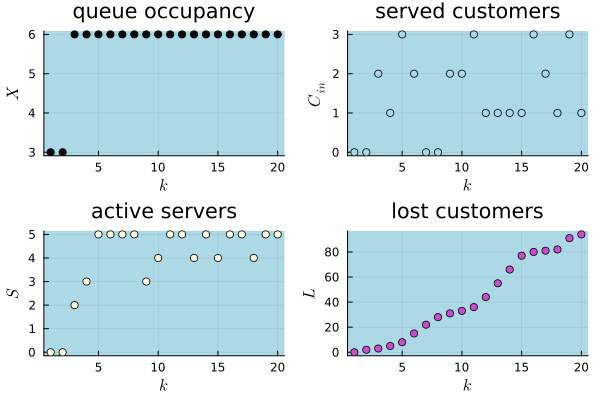

In [8]:
evolution = [X[1:horiz,1], Cin[1:horiz,1], S[1:horiz,1], L[1:horiz,1]]
ylabel = [L"X" L"C_{in}" L"S" L"L"]
title = ["queue occupancy" "served customers" "active servers" "lost customers"]

plotData(evolution, ylabel, title)

In [9]:
println("Total number of served customers: ", Z[horiz+1])
println("Total number of lost customers: ", L[horiz+1])

Total number of served customers: 24
Total number of lost customers: 106
